In [1]:
import os 
import sys
sys.path.append('/home/harry/Documents/Oxford/Projects/DESEMU/reference/jax-cosmo/jax_cosmo-master/')

from classy import Class  # pylint: disable-msg=E0611
from ml_collections.config_dict import ConfigDict
import numpy as np 
import jax_cosmo as jc
import jax

from jax import grad, jit, vmap, jacfwd, hessian
import matplotlib.pylab as plt 
import torch
from torchemu.gaussianprocess import GaussianProcess
from config import get_config
import pickle

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def delete_module(class_module: Class):
    """Deletes the module to prevent memory overflow.
    Args:
        module (Class): A CLASS module
    """
    class_module.struct_cleanup()

    class_module.empty()

    del class_module

In [3]:
def get_config(experiment) -> ConfigDict:
    config = ConfigDict()
    config.logname = "des-analysis"
    config.experiment = experiment

    # cosmological parameters
    config.cosmo = cosmo = ConfigDict()
    cosmo.names = ["sigma8", "Omega_cdm", "Omega_b", "h", "n_s"]

    # neutrino settings
    config.neutrino = neutrino = ConfigDict()
    neutrino.N_ncdm = 1.0
    neutrino.deg_ncdm = 3.0
    neutrino.T_ncdm = 0.71611
    neutrino.N_ur = 0.00641
    neutrino.fixed_nm = 0.06

    # CLASS settings
    config.classy = classy = ConfigDict()
    classy.bbn = '/home/harry/Desktop/class/bbn/sBBN.dat'
    classy.output = "mPk"
    classy.Omega_k = 0.0
    classy.k_max_pk = 50
    classy.k_min_pk = 1e-4
    classy.z_max_pk = 3.0
    classy.nk = 30
    classy.nz = 20

    # priors
    config.priors = {
        "sigma8": {
            "distribution": "uniform",
            "loc": 0.6,
            "scale": 0.4,
            "fiducial": 0.8,
        },
        "Omega_cdm": {
            "distribution": "uniform",
            "loc": 0.07,
            "scale": 0.43,
            "fiducial": 0.2,
        },
        "Omega_b": {
            "distribution": "uniform",
            "loc": 0.028,
            "scale": 0.027,
            "fiducial": 0.04,
        },
        "h": {"distribution": "uniform", "loc": 0.64, "scale": 0.18, "fiducial": 0.7},
        "n_s": {"distribution": "uniform", "loc": 0.87, "scale": 0.2, "fiducial": 1.0},
    }

    # emulator settings
    config.emu = emu = ConfigDict()
    emu.nlhs = 1000
    emu.jitter = 1e-10
    emu.lr = 0.01
    emu.nrestart = 5
    emu.niter = 1000

    return config

In [4]:
def class_args(config: ConfigDict) -> dict:
    """Generates CLASS arguments to be passed to classy to compute the different quantities.
    Args:
        config (ConfigDict): A configuration file containing the parameters.
    Returns:
        dict: A dictionary to input to class
    """
    dictionary = dict()
    dictionary['output'] = config.classy.output
    dictionary['P_k_max_1/Mpc'] = config.classy.k_max_pk
    dictionary['z_max_pk'] = config.classy.z_max_pk
    dictionary['Omega_k'] = config.classy.Omega_k
    dictionary['sBBN file'] = config.classy.bbn
    return dictionary

In [5]:
def neutrino_args(config: ConfigDict) -> dict:
    """Generates a dictionary for the neutrino settings.
    Args:
        config (ConfigDict): The main configuration file
    Returns:
        dict: A dictionary with the neutrino parameters.
    """
    dictionary = dict()
    dictionary['N_ncdm'] = config.neutrino.N_ncdm
    dictionary['deg_ncdm'] = config.neutrino.deg_ncdm
    dictionary['T_ncdm'] = config.neutrino.T_ncdm
    dictionary['N_ur'] = config.neutrino.N_ur
    dictionary['m_ncdm'] = config.neutrino.fixed_nm / config.neutrino.deg_ncdm
    return dictionary

In [6]:
def class_compute(config: ConfigDict, cosmology: dict) -> Class:
    """Pre-computes the quantities in CLASS.
    Args:
        config (ConfigDict): The main configuration file for running Class
        cosmology (dict): A dictionary with the cosmological parameters
    Returns:
        Class: A CLASS module
    """
    # generates the dictionaries to input to Class
    arg_class = class_args(config)
    arg_neutrino = neutrino_args(config)

    # Run Class
    class_module = Class()
    class_module.set(arg_class)
    class_module.set(arg_neutrino)
    class_module.set(cosmology)
    class_module.compute()

    return class_module

In [7]:
cfg = get_config('test')

In [8]:
cosmo = {'sigma8': 0.857570, 'Omega_cdm': 0.217284, 'Omega_b': 0.038872, 'h': 0.711447, 'n_s': 1.001982}
kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
zgrid = np.linspace(0.0, cfg.classy.z_max_pk, cfg.classy.nz)

In [10]:
def calculate_linear_pk_class(cosmology, cfg):
    """
    Calculate the linear matter power spectrum using CLASS
    """
    cmodule = class_compute(cfg, cosmology)
    
    # calculate the linear matter power spectrum
    kvalues = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    class_pklin = []
    for kvalue in kvalues:
        class_pklin.append(cosmology['h']**3 * cmodule.pk_lin(cosmology['h']*kvalue, 0.0))
    class_pklin = np.array(class_pklin)
    delete_module(cmodule)
    return class_pklin

In [11]:
class_pklin = calculate_linear_pk_class(cosmo, cfg)

# JAX Cosmo

In [12]:
def calculate_linear_pk_jax(cosmology, kvalues):
    """
    Calculate the linear matter power spectrum using JAX cosmo
    """
    jax_pklin = []
    for kvalue in kvalues:
        jax_pklin.append(jc.power.linear_matter_power(cosmology, kvalue, a=1.0))
    return jax_pklin

pklin_jit = jit(calculate_linear_pk_jax)

In [13]:
jcosmo =  jc.Cosmology(sigma8=0.857570, Omega_c=0.217284, Omega_b=0.038872, h=0.711447, n_s=1.001982, 
                      w0=-1., Omega_k=0., wa=0.)

In [14]:
%%capture
jax_pklin = pklin_jit(jcosmo, kgrid) 

In [15]:
jax_pklin_np =  np.concatenate([jax_pklin]) 

# Comparison

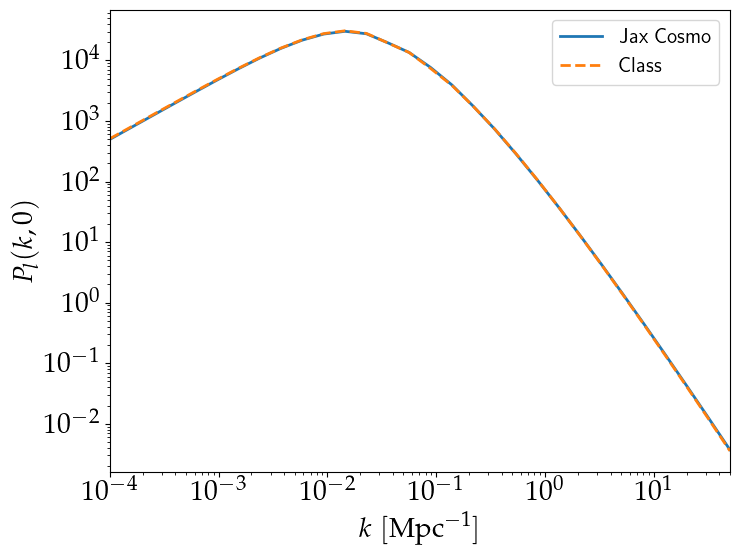

In [16]:
plt.figure(figsize = (8,6))
plt.loglog(kgrid, jax_pklin_np, lw = 2, label = 'Jax Cosmo')
plt.loglog(kgrid, class_pklin, lw = 2, linestyle = '--', label = 'Class')
plt.xlim(min(kgrid), max(kgrid))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$P_{l}(k,0)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Decompose the linear matter power spectrum

In [17]:
def calculate_quantities(cosmology, cfg):
    """
    Calculate the linear matter power spectrum at redshift 0 and the growth factor as a function of redshift
    """
    kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    zgrid = np.linspace(0.0, cfg.classy.z_max_pk, cfg.classy.nz)
    cmodule = class_compute(cfg, cosmology)
    class_pklin_z0 = []
    multiplying_factor = []
    # note that JAX cosmo computes everything with a factor h inside
    # which is why we are including the factor h here
    for kvalue in kgrid:
        class_pklin_z0.append(cosmology['h']**3 * cmodule.pk_lin(cosmology['h']*kvalue, 0))
    class_pklin_z0 = np.array(class_pklin_z0)
    
    for redshift in zgrid:
        factor = cosmology['h']**3 * cmodule.pk_lin(cosmology['h']*kgrid[0], redshift)
        multiplying_factor.append(factor / class_pklin_z0[0])
    multiplying_factor = np.array(multiplying_factor)
    delete_module(cmodule)
    return class_pklin_z0, multiplying_factor

In [18]:
def calculate_pklin_redshift(cosmology, cfg, redshift):
    """
    Calculate the linear matter power spectrum at any given redshift
    """
    kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    cmodule = class_compute(cfg, cosmology)
    class_pklin = []
    for kvalue in kgrid:
        class_pklin.append(cosmology['h']**3 * cmodule.pk_lin(cosmology['h']*kvalue, redshift))
    class_pklin = np.array(class_pklin)
    delete_module(cmodule)
    return class_pklin

In [19]:
%%time
class_pklin_z0, multiplying_factor = calculate_quantities(cosmo, cfg)

CPU times: user 14.4 s, sys: 20.2 ms, total: 14.4 s
Wall time: 2.54 s


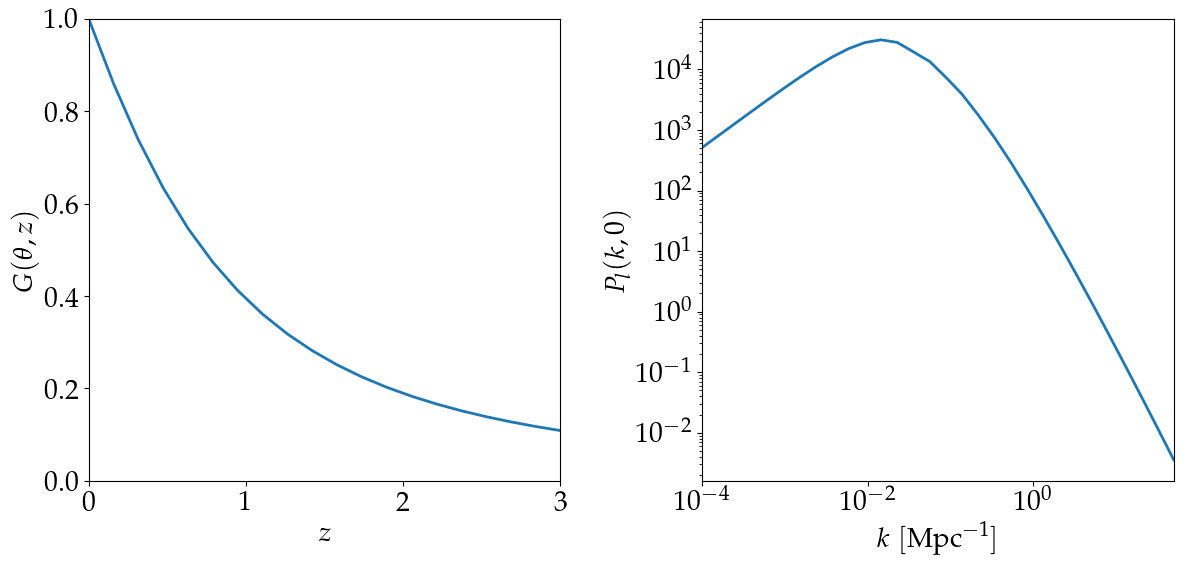

In [20]:
plt.figure(figsize = (14, 6))
plt.subplot(121)
plt.plot(zgrid, multiplying_factor, lw =2)
plt.ylabel(r'$G(\theta, z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 1)
plt.xlim(min(zgrid), max(zgrid))
plt.subplot(122)
plt.loglog(kgrid, class_pklin_z0, lw = 2)
plt.xlim(min(kgrid), max(kgrid))
plt.ylabel(r'$P_{l}(k,0)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.show()

# Any Redshift

In [20]:
testredshift = 1.0

In [21]:
class_pklin_z = calculate_pklin_redshift(cosmo, cfg, redshift=testredshift)
class_pklin_prod = class_pklin_z0 * np.interp(testredshift, zgrid, multiplying_factor)

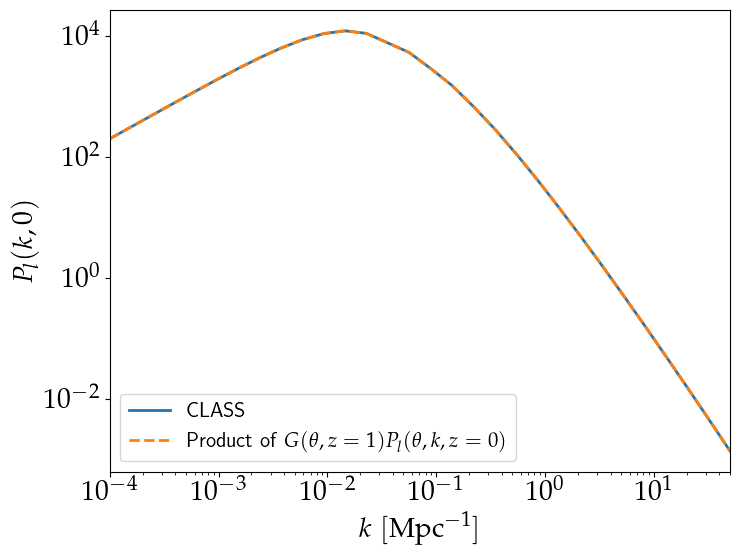

In [22]:
plt.figure(figsize=(8,6))
plt.loglog(kgrid, class_pklin_z, lw = 2, label = 'CLASS')
plt.loglog(kgrid, class_pklin_prod, lw = 2, linestyle = '--', label = r'Product of $G(\theta, z=1)P_{l}(\theta, k,z=0)$')
plt.xlim(min(kgrid), max(kgrid))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$P_{l}(k,0)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Generate Training Set

In [62]:
import pandas as pd 
import scipy.stats 

In [63]:
lhs = pd.read_csv('data/lhs_1000.csv', index_col=0)

In [64]:
lhs.head()

,V1,V2,V3,V4,V5
1,0.409403,0.707022,0.458449,0.696310,0.386550
2,0.399692,0.428306,0.845907,0.282958,0.316863
3,0.264020,0.819791,0.263440,0.769574,0.183617
4,0.315184,0.867452,0.182386,0.270367,0.815225
5,0.754065,0.470705,0.166511,0.343403,0.658752


In [65]:
def generate_cosmo_priors(cfg):
    """Generates the entity of each parameter by using scipy.stats function.
    Args:
        dictionary (dict): A dictionary with the specifications of the prior.
    Returns:
        dict: the prior distribution of all parameters.
    """
    dictionary = dict()
    for name in cfg.cosmo.names:
        param = cfg.priors[name]
        specs = (param.loc, param.scale)
        dictionary[name] = getattr(scipy.stats, param.distribution)(*specs)
    return dictionary

In [66]:
def generate_inputs(lhs, priors, save= False):
    """
    Generate the input training points (the cosmologies). This essentially scales the latin hypercube samples 
    according to the prior range of the cosmological parameters. 
    """
    
    cosmologies = {}
    for i, p in enumerate(priors):
        cosmologies[p] = priors[p].ppf(lhs.iloc[:,i].values)
    cosmologies = pd.DataFrame(cosmologies)
    if save:
        os.makedirs('data', exist_ok=True)
        cosmologies.to_csv('data/cosmologies.csv')
    return cosmologies

In [541]:
cosmo_priors = generate_cosmo_priors(cfg)
# cosmologies = generate_inputs(lhs, cosmo_priors, save = False)

In [370]:
cosmologies = pd.read_csv('data/cosmologies.csv', index_col = 0)

In [371]:
cosmologies.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.763761,0.374019,0.040378,0.765336,0.947310
1,0.759877,0.254172,0.050839,0.690932,0.933373
2,0.705608,0.422510,0.035113,0.778523,0.906723
3,0.726073,0.443004,0.032924,0.688666,1.033045
4,0.901626,0.272403,0.032496,0.701813,1.001750


In [69]:
def generate_outputs(cosmologies, cfg, save = False):
    ncosmo = cosmologies.shape[0]
    record_pklin = []
    record_gf = []
    for i in range(ncosmo):
        cosmology = dict(cosmologies.iloc[i])
        train_pklin, train_gf = calculate_quantities(cosmology, cfg)
        record_pklin.append(train_pklin)
        record_gf.append(train_gf)
    record_pklin = pd.DataFrame(record_pklin)
    record_gf = pd.DataFrame(record_gf)
    if save:
        os.makedirs('data', exist_ok=True)
        record_pklin.to_csv('data/pklin.csv')
        record_gf.to_csv('data/gf.csv')
    return record_pklin, record_gf

In [ ]:
%%time 
# record_pklin, record_gf = generate_outputs(cosmologies, cfg, save=True) # this should be done once
# this took about 1 hour

In [367]:
record_pklin = pd.read_csv('data/pklin.csv', index_col=0)
record_gf = pd.read_csv('data/gf.csv', index_col = 0 )

In [368]:
record_pklin.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,131.445968,201.760798,309.614593,474.847080,727.277316,1110.629576,1686.057567,2531.627176,3730.727684,5330.572047,...,118.263062,43.401857,15.162146,5.090355,1.654540,0.523642,0.162088,0.049241,0.014719,0.004337
1,487.772462,743.862127,1133.846530,1726.266292,2621.222199,3957.890703,5912.218508,8667.205058,12325.786242,16717.196546,...,79.993508,27.648291,9.193537,2.961906,0.929661,0.285503,0.086076,0.025541,0.007471,0.002156
2,108.107721,162.923525,245.485314,369.710123,556.181295,834.668196,1246.424207,1843.920417,2684.034096,3802.660875,...,105.901752,38.851374,13.517810,4.507275,1.451882,0.454627,0.139055,0.041701,0.012297,0.003573
3,51.563186,82.277781,131.258554,209.284397,333.269242,529.226999,835.669259,1305.675276,2003.269165,2983.381997,...,129.215736,49.719024,18.177218,6.377798,2.164260,0.714557,0.230606,0.073010,0.022739,0.006981
4,318.827723,501.501366,788.460400,1238.201521,1939.421478,3021.143607,4656.975309,7047.633228,10352.551881,14518.223204,...,135.719182,48.823120,16.864521,5.636024,1.833043,0.582858,0.181837,0.055811,0.016887,0.005042


In [369]:
record_gf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.824241,0.682947,0.570414,0.480844,0.409225,0.351530,0.304637,0.266167,0.234311,0.207693,0.185261,0.166205,0.149894,0.135837,0.123642,0.113001,0.103662,0.095425,0.088124
1,1.0,0.847581,0.718381,0.610835,0.522128,0.449162,0.389058,0.339345,0.297994,0.263376,0.234197,0.209433,0.188277,0.170084,0.154345,0.140649,0.128665,0.118125,0.108811,0.100543
2,1.0,0.816190,0.671178,0.557389,0.467854,0.396889,0.340104,0.294188,0.256670,0.225698,0.199882,0.178169,0.159752,0.144008,0.130454,0.118706,0.108461,0.099477,0.091555,0.084538
3,1.0,0.812879,0.666402,0.552156,0.462674,0.391998,0.335591,0.290073,0.252937,0.222318,0.196820,0.175390,0.157224,0.141704,0.128346,0.116773,0.106683,0.097836,0.090038,0.083131
4,1.0,0.847620,0.718441,0.610905,0.522202,0.449235,0.389128,0.339411,0.298055,0.263432,0.234249,0.209481,0.188321,0.170125,0.154383,0.140684,0.128697,0.118156,0.108839,0.100569


# Emulator

In [74]:
inputs = torch.from_numpy(cosmologies.values)
outputs_pklin = torch.from_numpy(record_pklin.values)
outputs_gf = torch.from_numpy(record_gf.values[:,1:])

In [75]:
def save_pkl(file: dict, folder_name: str, file_name: str) -> None:
    """Stores a list/dict/class in a folder.

    Args:
        file (list): Quantity to store.
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    """

    # create the folder if it does not exist
    os.makedirs(folder_name, exist_ok=True)

    # use compressed format to store data
    with open(folder_name + "/" + file_name + ".pkl", "wb") as f:
        pickle.dump(file, f)


def load_pkl(folder_name: str, file_name: str) -> dict:
    """Reads a list from a folder.

    Args:
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.

    Returns:
        dict: the dictionary with all the quantities.
    """
    with open(folder_name + "/" + file_name + ".pkl", "rb") as f:
        file = pickle.load(f)

    return file

In [76]:
def train_gps(configs, cosmologies, outputs, prewhiten, ylog, fname='pklin'):
    nout = outputs.shape[1]
    record = []
    for i in range(nout):
        
        # optimise for the kernel parameters
        gpmodule = GaussianProcess(configs, inputs, outputs[:,i], prewhiten=prewhiten, ylog=ylog)
        parameters = torch.randn(6)
        opt_params = gpmodule.optimisation(parameters, niter=configs.emu.niter, lrate=configs.emu.lr, nrestart = configs.emu.nrestart)

        # save the gps and quantities
        save_pkl(gpmodule, 'gps', fname+f'_{i}')
        record.append(gpmodule)
    return record

In [304]:
def save_quantities(gps, fname):
    for i, gpmodule in enumerate(gps):
        # record all quantities to be used for Jax 
        quantities = {}
        quantities['hyperparams'] = gpmodule.opt_parameters.data.numpy()
        quantities['cholfactor'] = gpmodule.chol_train.data.numpy()
        quantities['meanparams'] = gpmodule.mean_train.data.numpy()
        quantities['alpha'] = gpmodule.alpha.data.numpy()
        quantities['ystd'] = gpmodule.ystd.data.numpy()
        quantities['ymean'] = gpmodule.ymean.data.numpy()
        quantities['xtrain'] = gpmodule.xtrain.data.numpy()
        save_pkl(quantities, 'quantities', fname+f'_{i}')

In [77]:
%%time
# gps_pklin = train_gps(cfg, inputs, outputs_pklin, True, True, 'pklin') # this is done once
# CPU times: user 10h 24min 47s, sys: 7min 8s, total: 10h 31min 56s
# Wall time: 1h 19min 28s

CPU times: user 10h 24min 47s, sys: 7min 8s, total: 10h 31min 56s
Wall time: 1h 19min 28s


In [78]:
%%time
# gps_gf = train_gps(cfg, inputs, outputs_gf, True, False, 'gf') # this is done once
# CPU times: user 6h 38min 19s, sys: 1min 34s, total: 6h 39min 54s
# Wall time: 50min 18s

Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
Not using log transformation
CPU times: user 6h 38min 19s, sys: 1min 34s, total: 6h 39min 54s
Wall time: 50min 18s


In [305]:
# save_quantities(gps_pklin, 'pklin')
# save_quantities(gps_gf, 'gf')

# Testing

We just need to load the trained GPs before making predictions

In [219]:
loaded_gps_pklin = [load_pkl('gps/', f'pklin_{i}') for i in range(cfg.classy.nk)]
loaded_gps_gf = [load_pkl('gps/', f'gf_{i}') for i in range(cfg.classy.nz-1)]

In [208]:
ndim = 5
ntest = 250
test_samples = pd.DataFrame(np.random.uniform(0, 1, (ntest, ndim)), columns=[f'V{i+1}' for i in range(ndim)])
test_cosmo = generate_inputs(test_samples, cosmo_priors, save=False)

In [209]:
test_cosmo.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.933523,0.096535,0.035931,0.816626,0.902618
1,0.703781,0.406330,0.030712,0.802787,0.978740
2,0.970848,0.225575,0.052117,0.670489,1.011479
3,0.882411,0.299605,0.045590,0.692735,0.875245
4,0.988539,0.158993,0.038272,0.733096,1.019198


In [210]:
def interpolate_1d(fine_x, coarse_x, coarse_y, xlog=False, ylog=False):
    if xlog:
        fine_x = np.log(fine_x)
        coarse_x = np.log(coarse_x)
    if ylog:
        coarse_y = np.log(coarse_y)
    ypred = np.interp(fine_x, coarse_x, coarse_y)
    if ylog:
        ypred = np.exp(ypred)
    return ypred

In [257]:
def calculate_accuracy(gps_pklin, gps_gf, testcosmo, cfg, use_interp: bool):
    
    # coarse and fine grid for wavenumber
    kgrid = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, cfg.classy.nk)
    kfine = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, 1000)
    
    # coarse and fine grid for redshift
    zgrid = np.linspace(0.0, cfg.classy.z_max_pk, cfg.classy.nz)
    zfine = np.linspace(0.0, cfg.classy.z_max_pk, 1000)
    
    ntest = testcosmo.shape[0]
    record = {'class_pklin': [],
              'class_gf': [],
              'gp_pklin': [],
              'gp_gf': [],
              'delta_pklin': [],
              'delta_gf': []
             }
    for i in range(ntest):
        cosmo_dict = dict(testcosmo.iloc[i])
        cosmo_tensor = torch.tensor(testcosmo.iloc[i].values).view(-1)
        
        pklin_class, gf_class = calculate_quantities(cosmo_dict, cfg)
        pklin_gp = [gps_pklin[j].prediction(cosmo_tensor).item() for j in range(cfg.classy.nk)]
        gf_gp = [1] + [gps_gf[j].prediction(cosmo_tensor).item() for j in range(cfg.classy.nz-1)]
        
        if use_interp:
            pklin_class = interpolate_1d(kfine, kgrid, pklin_class, xlog=True, ylog=True)
            pklin_gp = interpolate_1d(kfine, kgrid, pklin_gp, xlog=True, ylog=True)
            gf_gp = interpolate_1d(zfine, zgrid, gf_gp, xlog=False, ylog=False)
            gf_class = interpolate_1d(zfine, zgrid, gf_class, xlog=False, ylog=False)
        
        record['class_pklin'].append(pklin_class)
        record['class_gf'].append(gf_class)
        record['gp_pklin'].append(np.array(pklin_gp))
        record['gp_gf'].append(np.array(gf_gp))
        record['delta_pklin'].append((pklin_class - pklin_gp)/pklin_class)
        record['delta_gf'].append((gf_class - gf_gp)/gf_class)
        record['testcosmo'] = testcosmo
        
    save_pkl(record, 'data', 'accuracy')
        
    return record

In [213]:
%%time
record = calculate_accuracy(loaded_gps_pklin, loaded_gps_gf, test_cosmo, cfg, use_interp=True)

CPU times: user 1h 7min 21s, sys: 1.86 s, total: 1h 7min 23s
Wall time: 11min 23s


In [378]:
record.keys()

dict_keys(['class_pklin', 'class_gf', 'gp_pklin', 'gp_gf', 'delta_pklin', 'delta_gf', 'testcosmo'])

In [214]:
delta_pklin = np.vstack(record['delta_pklin'])
delta_gf = np.vstack(record['delta_gf'])

mean_delta_pklin = np.mean(delta_pklin, axis = 0)*100
std_delta_pklin = np.std(delta_pklin, axis = 0)*100

mean_delta_gf = np.mean(delta_gf, axis = 0)*100
std_delta_gf = np.std(delta_gf, axis = 0)*100

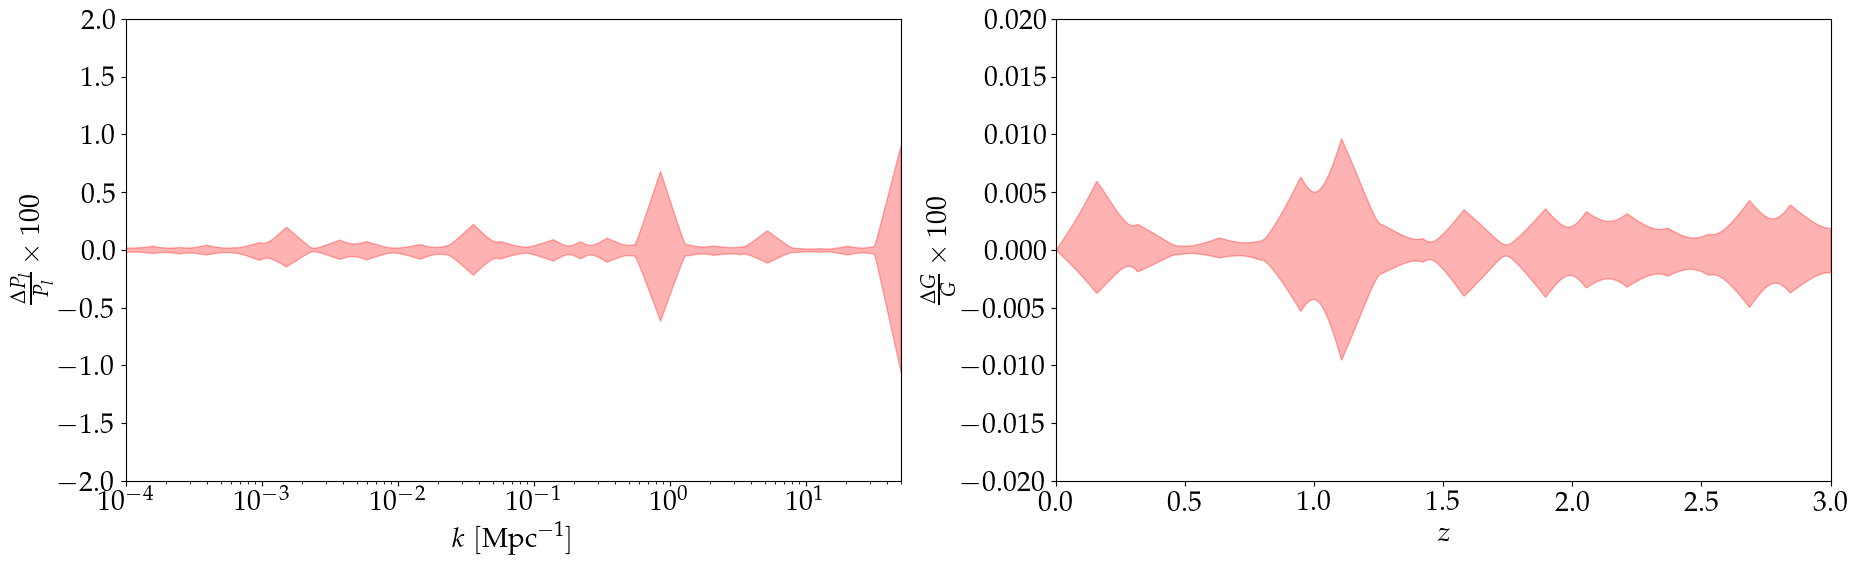

In [216]:
kfine = np.geomspace(cfg.classy.k_min_pk, cfg.classy.k_max_pk, 1000)
zfine = np.linspace(0.0, cfg.classy.z_max_pk, 1000)
    
plt.figure(figsize = (22,6))
plt.subplot(121)
plt.fill_between(kfine, mean_delta_pklin + 3 * std_delta_pklin, mean_delta_pklin - 3 * std_delta_pklin, alpha = 0.3, color = 'r')
plt.ylim(-2, 2)
plt.xlim(min(kgrid), max(kgrid))
plt.ylabel(r'$\frac{\Delta P_{l}}{P_{l}}\times 100$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xscale('log')

plt.subplot(122)
plt.fill_between(zfine, mean_delta_gf + 3 * std_delta_gf, mean_delta_gf - 3 * std_delta_gf, alpha = 0.3, color = 'r')
plt.ylim(-0.02, 0.02)
plt.xlim(min(zgrid), max(zgrid))
plt.ylabel(r'$\frac{\Delta G}{G}\times 100$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# GP Implementation in $\texttt{Numpy}$
If we are able to do this with $\texttt{numpy}$, it should be the same for Jax using $\texttt{jax.numpy}$.

In [548]:
def pairwise_distance_numpy(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
    sqr_a = np.broadcast_to(np.sum(np.power(arr1, 2), axis=1, keepdims=True), (arr1.shape[0], arr2.shape[0]))
    sqr_b = np.broadcast_to(np.sum(np.power(arr2, 2), axis=1, keepdims=True), (arr2.shape[0], arr1.shape[0])).T
    dist = sqr_a - 2 * arr1 @ arr2.T + sqr_b
    return dist

In [549]:
def compute_numpy(arr1: np.ndarray, arr2: np.ndarray, hyper: np.ndarray) -> np.ndarray:
    _, ndim = arr1.shape
    arr2 = arr2.reshape(-1, ndim)
    hyper = hyper.reshape(1, ndim + 1)
    arr1 = arr1 / np.exp(hyper[:, 1:])
    arr2 = arr2 / np.exp(hyper[:, 1:])
    dist = pairwise_distance_numpy(arr1, arr2)
    kernel = np.exp(hyper[:, 0]) * np.exp(-0.5 * dist)
    return kernel 

In [550]:
def xtransform_numpy(xtest: np.ndarray, cholfactor: np.ndarray, meanparams: np.ndarray):
    xtest = xtest.reshape(1, -1)
    xtest_trans = np.linalg.inv(cholfactor) @ (xtest - meanparams).T
    xtest_trans = xtest_trans.T
    return xtest_trans

In [819]:
def prediction_numpy(xtest: np.ndarray, quantities: list, cosmo_priors: dict, ylog: bool = True):
    
    logpdf = calculate_cosmo_pdf(cosmo_priors, xtest)
    if not np.isfinite(logpdf):
        raise ValueError('The cosmological parameter lies outside the prior volume.')

    # the cosmologies are fixed and the cholesky factor is the same for all 
    xtest = xtransform_numpy(xtest, quantities[0]['cholfactor'], quantities[0]['meanparams'])
    ngps = len(quantities)
    predictions = []
    for i in range(ngps):
        kstar = compute_numpy(quantities[i]['xtrain'], xtest, quantities[i]['hyperparams'])
        pred = kstar.T @ quantities[i]['alpha'] 
        pred = pred * quantities[i]['ystd'] + quantities[i]['ymean']
        if ylog:
            pred = np.exp(pred).reshape(-1)
        predictions.append(pred.item())
    return predictions

In [698]:
def calculate_cosmo_pdf(cosmo_priors: dict, point: np.ndarray):
    logpdf = 0.0
    for i, key in enumerate(cosmo_priors.keys()):
        logpdf += cosmo_priors[key].logpdf(point[i])
    return logpdf

Quantities we need to predict the different functions. 

In [699]:
quantities_pklin = [load_pkl('quantities', f'pklin_{i}') for i in range(cfg.classy.nk)]
quantities_gf = [load_pkl('quantities', f'gf_{i}') for i in range(cfg.classy.nz-1)]

The test point we want to use for this check. 

In [554]:
testpoint = test_cosmo.iloc[0].values
testpoint_pt = torch.from_numpy(testpoint)
testpoint_dict = dict(test_cosmo.iloc[0])

Make sure that the point lies within the prior volume - this is also tested within the prediction function

In [555]:
calculate_cosmo_pdf(cosmo_priors, testpoint)

8.696415555672518

In [556]:
calculate_cosmo_pdf(cosmo_priors, testpoint+1)

-inf

The linear matter power spectrum and the growth factor using $\texttt{numpy}$ or $\texttt{jax.numpy}$ (should be the same approach). 

In [820]:
%%time
pklin_np = prediction_numpy(testpoint, quantities_pklin, cosmo_priors, ylog=True)
gf_np = [1.0] + prediction_numpy(testpoint, quantities_gf, cosmo_priors, ylog=False)

CPU times: user 27.9 ms, sys: 36.1 ms, total: 63.9 ms
Wall time: 10 ms


The linear matter power spectrum and the growth factor using $\texttt{pyTorch}$. 

In [558]:
%%time
pklin_pt = [gps_pklin[j].prediction(testpoint_pt).item() for j in range(cfg.classy.nk)]
gf_pt = [1.0] + [gps_gf[j].prediction(testpoint_pt).item() for j in range(cfg.classy.nz-1)]

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 11.2 ms


The linear matter power spectrum and the growth factor using $\texttt{CLASS}$.

In [559]:
%%time
pklin_class, gf_class = calculate_quantities(testpoint_dict, cfg)

CPU times: user 19.1 s, sys: 16 ms, total: 19.1 s
Wall time: 3.48 s


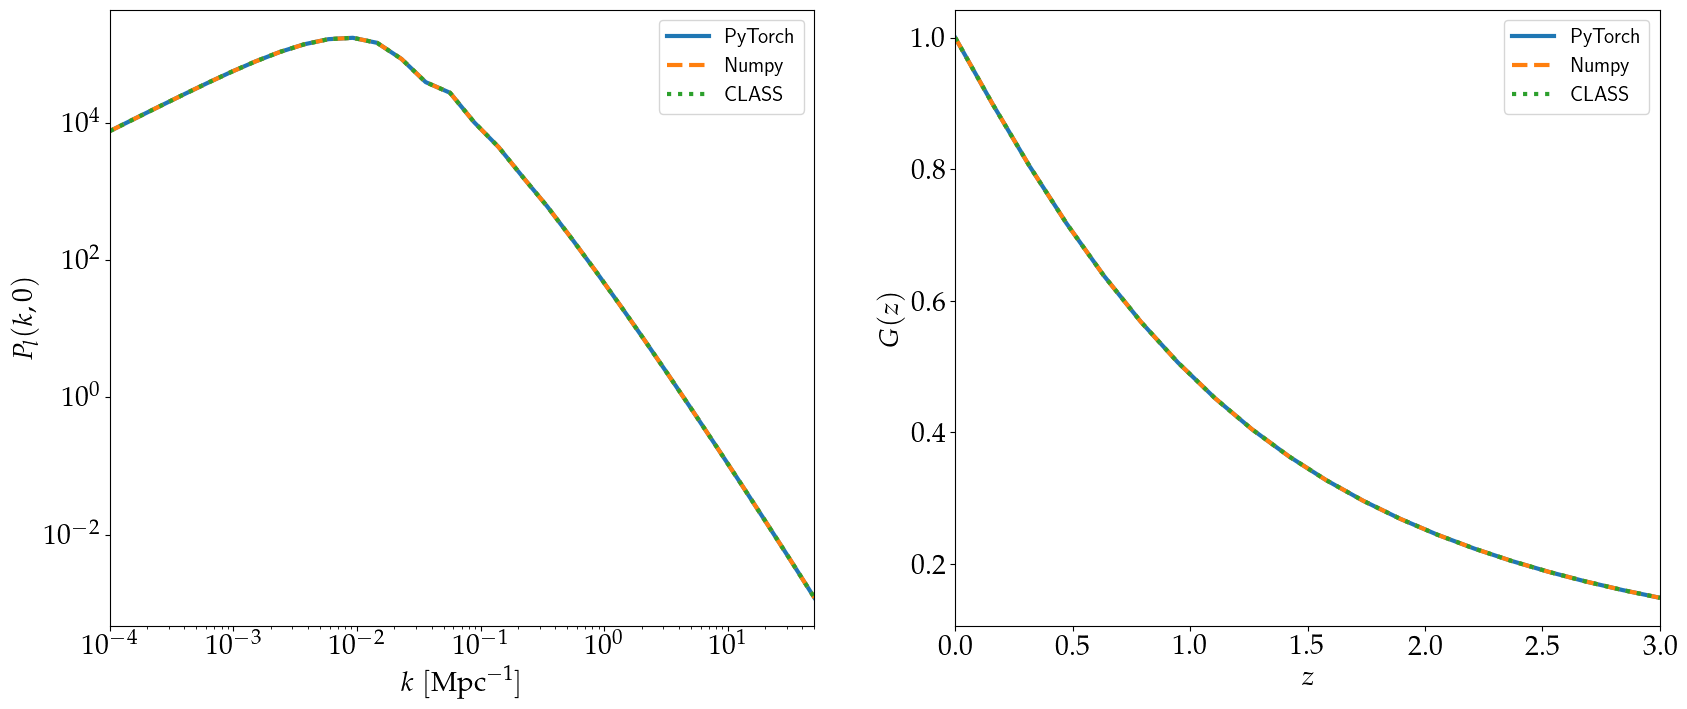

In [560]:
plt.figure(figsize = (20,8))
plt.subplot(121)
plt.loglog(kgrid, pklin_pt, lw = 3, label = 'PyTorch')
plt.loglog(kgrid, pklin_np, lw = 3, linestyle = '--', label = 'Numpy')
plt.loglog(kgrid, pklin_class, lw = 3, linestyle = ':', label = 'CLASS')
plt.xlim(min(kgrid), max(kgrid))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$P_{l}(k,0)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)

plt.subplot(122)
plt.plot(zgrid, gf_pt, lw = 3, label = 'PyTorch')
plt.plot(zgrid, gf_np, lw = 3, linestyle = '--', label = 'Numpy')
plt.plot(zgrid, gf_class, lw = 3, linestyle = ':', label = 'CLASS')
plt.xlim(min(zgrid), max(zgrid))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$G(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# GP Implementation in $\texttt{jax.numpy}$

In [615]:
import jax.numpy as jnp
import jax.scipy.stats as jss
from scipy import interpolate
from jax.config import config; config.update("jax_enable_x64", True)

We need a dictionary of priors defined outside the function, for the latter to be differentiable. 

In [640]:
COSMO_PRIORS = {'sigma8': {'distribution': 'uniform', 'loc': 0.6, 'scale': 0.4},
                'Omega_cdm': {'distribution': 'uniform', 'loc': 0.07, 'scale': 0.43},
                'Omega_b': {'distribution': 'uniform', 'loc': 0.028, 'scale': 0.027},
                'h': {'distribution': 'uniform', 'loc': 0.64, 'scale': 0.18},
                'n_s': {'distribution': 'uniform', 'loc': 0.87, 'scale': 0.2}
               }

In [617]:
def pairwise_distance_jax(arr1: jnp.ndarray, arr2: jnp.ndarray) -> jnp.ndarray:
    sqr_a = jnp.broadcast_to(jnp.sum(jnp.power(arr1, 2), axis=1, keepdims=True), (arr1.shape[0], arr2.shape[0]))
    sqr_b = jnp.broadcast_to(jnp.sum(jnp.power(arr2, 2), axis=1, keepdims=True), (arr2.shape[0], arr1.shape[0])).T
    dist = sqr_a - 2 * arr1 @ arr2.T + sqr_b
    return dist

In [649]:
def compute_jax(arr1: jnp.ndarray, arr2: jnp.ndarray, hyper: jnp.ndarray) -> jnp.ndarray:
    _, ndim = arr1.shape
    arr2 = arr2.reshape(-1, ndim)
    hyper = hyper.reshape(1, ndim + 1)
    arr1 = arr1 / jnp.exp(hyper[:, 1:])
    arr2 = arr2 / jnp.exp(hyper[:, 1:])
    dist = pairwise_distance_jax(arr1, arr2)
    kernel = jnp.exp(hyper[:, 0]) * jnp.exp(-0.5 * dist)
    return kernel 

In [650]:
def xtransform_jax(xtest: jnp.ndarray, cholfactor: jnp.ndarray, meanparams: jnp.ndarray):
    xtest = xtest.reshape(1, -1)
    xtest_trans = jnp.linalg.inv(cholfactor) @ (xtest - meanparams).T
    xtest_trans = xtest_trans.T
    return xtest_trans

In [651]:
def convert_dict_nparray_jaxarray(dictionary):
    record = {}
    for key in dictionary:
        record[key] = jnp.asarray(dictionary[key])
    return record

In [652]:
def calculate_cosmo_logpdf_jax(testpoint: dict):
    """Generates the entity of each parameter by using scipy.stats function.
    Args:
        dictionary (dict): A dictionary with the specifications of the prior.
    Returns:
        dict: the prior distribution of all parameters.
    """
    logpdf = jnp.zeros(1)
    for key in testpoint:
        function = getattr(getattr(jss, COSMO_PRIORS[key]['distribution']), 'logpdf')
        logpdf += function(testpoint[key], COSMO_PRIORS[key]['loc'], COSMO_PRIORS[key]['scale'])
    return logpdf

In [653]:
def jaxarray_to_dict(point: jnp.ndarray) -> dict:
    keys = COSMO_PRIORS.keys()
    param = {}
    for i, key in enumerate(keys):
        param[key] = point[i]
    return param

In [751]:
def prediction_jax(xtest: jnp.ndarray, quantities: list):
    # the cosmologies are fixed and the cholesky factor is the same for all 
    xtest_trans = xtransform_jax(xtest, quantities[0]['cholfactor'], quantities[0]['meanparams'])
    ngps = len(quantities)
    predictions = []
    for i in range(ngps):
        kstar = compute_jax(quantities[i]['xtrain'], xtest_trans, quantities[i]['hyperparams'])
        pred = kstar.T @ quantities[i]['alpha'] 
        pred = pred * quantities[i]['ystd'] +  quantities[i]['ymean']
        predictions.append(pred)
    predictions = jnp.asarray(predictions).reshape(-1)
    return predictions

In [752]:
def prediction_pklin_jax(xtest: jnp.ndarray, quantities: list):
    ypred = prediction_jax(xtest, quantities)
    return jnp.exp(ypred)

In [759]:
def prediction_gf_jax(xtest: jnp.ndarray, quantities: list):
    ypred = prediction_jax(xtest, quantities)
    return jnp.concatenate([jnp.ones(1), ypred])

Check that the log-prior is fully differentiable. 

In [625]:
jacobian_prior = jit(jacfwd(calculate_cosmo_logpdf_jax))

In [626]:
point = jaxarray_to_dict(test_cosmo.iloc[0].values)

In [627]:
calculate_logpdf_jax(point)

Array([8.69641556], dtype=float64)

In [628]:
jacobian_prior(point)

{'Omega_b': Array([0.], dtype=float64),
 'Omega_cdm': Array([0.], dtype=float64),
 'h': Array([0.], dtype=float64),
 'n_s': Array([0.], dtype=float64),
 'sigma8': Array([0.], dtype=float64)}

The stored quantities are in ordinary numpy arrays. We need jax numpy arrays.

### Predict the Power Spectrum with JAX

In [687]:
point_jax = jnp.array(test_cosmo.iloc[0].values)

In [753]:
pklin_jax_0 = prediction_pklin_jax(point_jax, quantities_pklin)
gf_jax_0 = prediction_gf_jax(point_jax, quantities_gf)

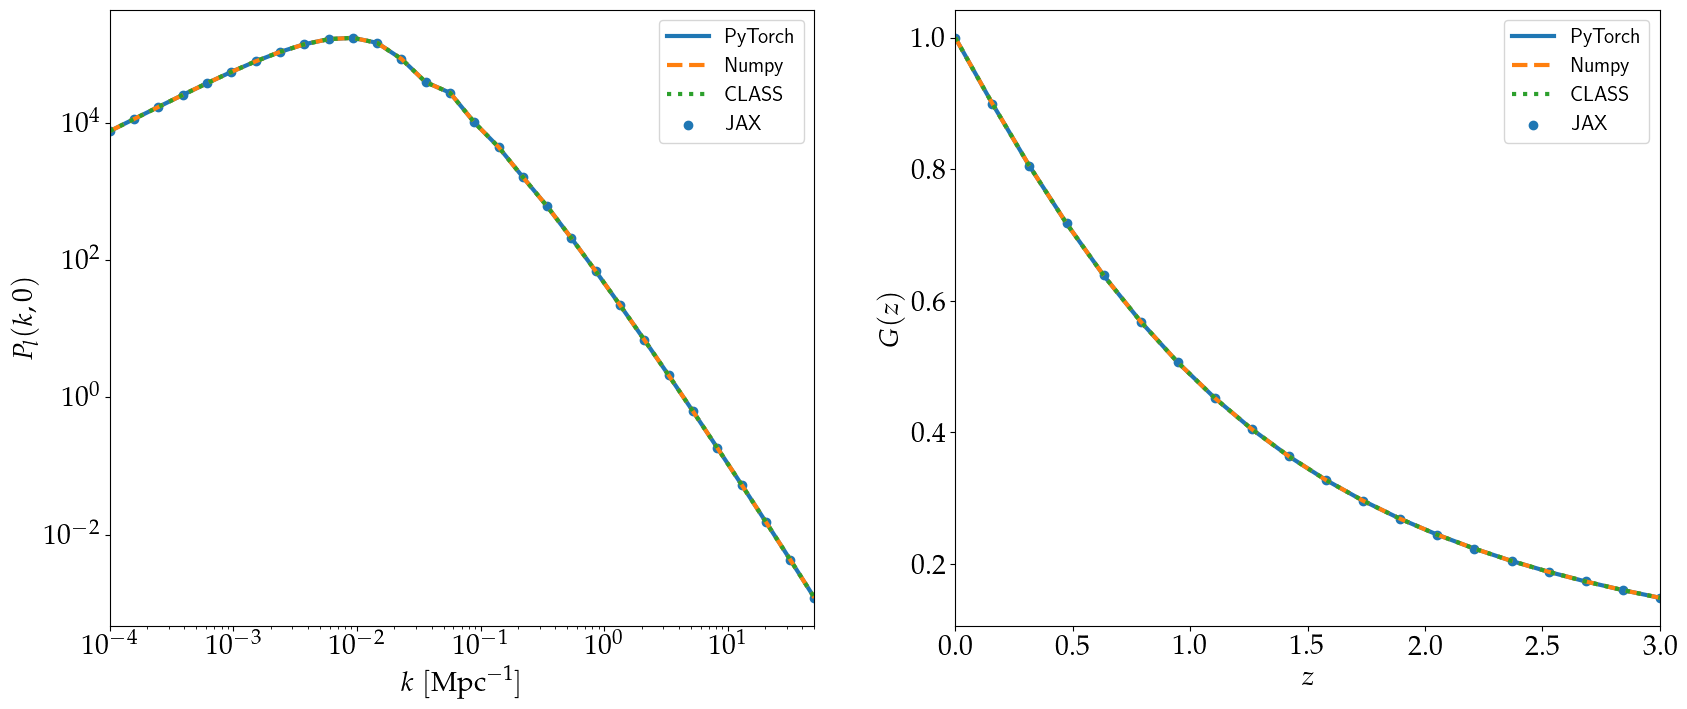

In [818]:
plt.figure(figsize = (20,8))
plt.subplot(121)
plt.loglog(kgrid, pklin_pt, lw = 3, label = 'PyTorch')
plt.loglog(kgrid, pklin_np, lw = 3, linestyle = '--', label = 'Numpy')
plt.loglog(kgrid, pklin_class, lw = 3, linestyle = ':', label = 'CLASS')
plt.scatter(kgrid, pklin_jax_0, label = 'JAX')
plt.xlim(min(kgrid), max(kgrid))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$P_{l}(k,0)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)

plt.subplot(122)
plt.plot(zgrid, gf_pt, lw = 3, label = 'PyTorch')
plt.plot(zgrid, gf_np, lw = 3, linestyle = '--', label = 'Numpy')
plt.plot(zgrid, gf_class, lw = 3, linestyle = ':', label = 'CLASS')
plt.scatter(zgrid, gf_jax_0, label = 'JAX')
plt.xlim(min(zgrid), max(zgrid))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$G(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

Jacobian of the linear matter power spectrum.

In [755]:
jacobian_pklin = jit(jacfwd(prediction_pklin_jax))

In [762]:
%%time
jac_pklin = jacobian_pklin(point_jax, quantities_pklin)

CPU times: user 3.43 ms, sys: 10 µs, total: 3.44 ms
Wall time: 3.17 ms


Finite difference using CLASS.

In [874]:
point_fd = test_cosmo.iloc[0]
eps = 1E-3

In [891]:
jac_class = {}
for i, key in enumerate(point_fd.keys()):
    point_fd_p = point_fd.copy()
    point_fd_n = point_fd.copy()
    point_fd_p[i] += eps 
    point_fd_n[i] -= eps
    pklin_class_p, gf_class_p = calculate_quantities(dict(point_fd_p), cfg)
    pklin_class_n, gf_class_n = calculate_quantities(dict(point_fd_n), cfg)
    jac_class[key] = (pklin_class_p - pklin_class_n) / (2*eps)

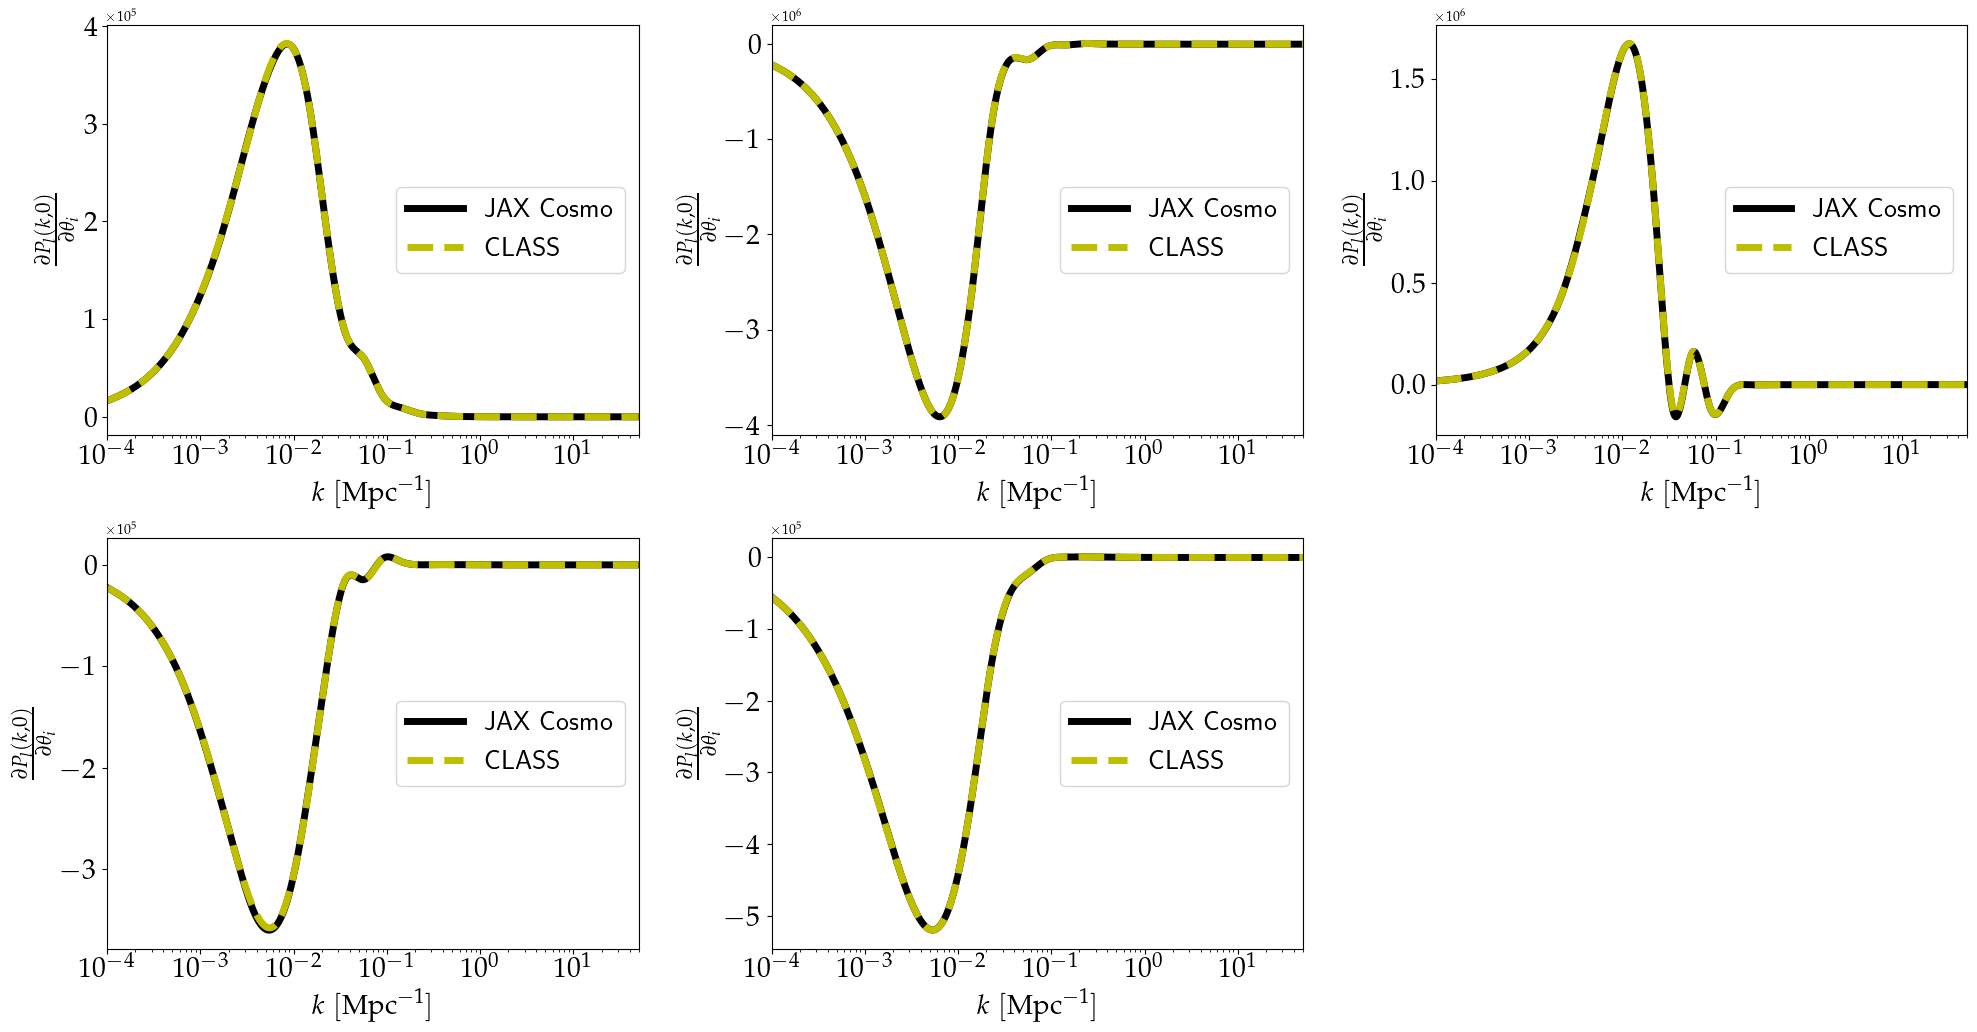

In [898]:
labels = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$']
plt.figure(figsize = (24, 12))
for i, key in enumerate(point_fd.keys()):
    spline = interpolate.splrep(np.log(kgrid), jac_pklin[:,i])
    ynew = interpolate.splev(np.log(kfine), spline)
    
    spline_class = interpolate.splrep(np.log(kgrid), jac_class[key])
    ynew_class = interpolate.splev(np.log(kfine), spline_class)
    
    plt.subplot(2, 3, i+1)
    plt.plot(kfine, ynew, lw = 5, label = 'JAX Cosmo', c = 'k')
    plt.plot(kfine, ynew_class, lw = 5, linestyle = '--', label = 'CLASS', c = 'y')
    plt.xlim(min(kgrid), max(kgrid))
    plt.ylabel(r'$\frac{\partial P_{l}(k,0)}{\partial \theta_{i}}$', fontsize = fontSize)
    plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.legend(loc = 'center right',prop={'family':'sans-serif', 'size':20})
    plt.xscale('log')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

# To Do 

- Couple this code to Jax-Cosmo.
- Check settings for cosmology ($\ell_{min}, \ell_{max}, \theta_{fid}, k_{max}$).
- Check $\chi^{2}$.
- Improve script to run Cobaya for any test point. 